## Part III: Feature Engineering and Data Preparation

#### Setup Environment

In [1]:
%run environment-setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 's3_datalake_path_prepared' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import additional libs needed
from sklearn.preprocessing import StandardScaler
from sepsis_helpers import DeteriorationIndex

In [4]:
# load the cleaned datset from Athena/S3
sepsis_dataset = load_clean_dataset()

2024-11-19 16:58:09,095	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 904921088 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.17gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-11-19 16:58:10,284	INFO worker.py:1786 -- Started a local Ray instance.


In [73]:
full_x = np.ndarray((1,), dtype=int)
dr = sepsis_dataset[sepsis_dataset['patient_id'] == 9]
di = DeteriorationIndex(dr)
x1 = di.patient_deterioration_index()
full_x = np.concatenate((full_x, x1), axis=0)
dr2 = sepsis_dataset[sepsis_dataset['patient_id'] == 11093]
di = DeteriorationIndex(dr2)
x2 = di.patient_deterioration_index()

full_x = np.concatenate((full_x, x2), axis=0)
full_x.reshape(-1, 1)
#print(full_x)
#np.max(dr['wbc'])

array([[4667324055571922944],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [                  9],
       [  

### Data Transformation

The dataset is cleaned and complete, however additional work is still required to prepare for modeling.  In this section, the following steps will be taken:

-  Encode categorical features
-  Transform the time series data into patient time series sequences
-  Split dataset: the dataset will be split in to train/val/test sets
-  Normalize dataset: the dataset will be normalized using a standard scaler

In [8]:
# helper function to create lag features
def create_lag_features(df, lag_step, feature_cols):
    # get all unique patients
    unique_patient_ids = df['patient_id'].unique()
    
    # create matrix for lag features 
    lag_features = np.zeros(shape=(df.shape[0], len(feature_cols)))
    lag_column_names = [x.lower() + '_t_' + str(lag_step) for x in feature_cols]
    lag_features_found = np.zeros(shape=len(feature_cols))
    feature_cols = [x.lower() for x in feature_cols]
    
    # iterate patients
    row_counter = 0
    for patient_id in unique_patient_ids:
        patient_records = df[df['patient_id'] == patient_id].sort_values(by=['hour'], ascending=True)
        patient_row_counter = 0
        for idx, patient_record in patient_records.iterrows():
            for col_idx, col in enumerate(feature_cols):
                if(patient_row_counter == 0):
                    lag_features[row_counter, col_idx] = patient_record[col]
                else:
                    lag_features[row_counter, col_idx] = patient_records.iloc[patient_row_counter - 1][col]
            row_counter += 1
            patient_row_counter += 1

    return pd.concat([df, pd.DataFrame(index=df.index, data=lag_features, columns=lag_column_names)], axis=1)

# create an index to indicate deterioration in vitals and labs over given set of time steps
def create_deterioration_index(df):

    # add new feature column to df

    # get all unique patients
    deterioration_scores = []
    unique_patient_ids = df['patient_id'].unique()
    
    # create matrix for lag features 
    deterioration_feature_cols = ['deterioration_index']
        
    # iterate patients and calc score
    for patient_id in unique_patient_ids:
        patient_records = df[df['patient_id'] == patient_id].sort_values(by=['hour'], ascending=True)
        deterioration_helper = DeteriorationIndex(patient_records)
        patient_d_scores = deterioration_helper.patient_full_deterioration_index()
        if(len(deterioration_scores) == 0):
            deterioration_scores = patient_d_scores
        else:
            deterioration_scores = np.concatenate((deterioration_scores, patient_d_scores), axis=0)
    
    return pd.concat([df, pd.DataFrame(index=df.index, data=deterioration_scores.reshape(-1,1), columns=deterioration_feature_cols)], axis=1)

In [28]:
# create the lag features for t-1
sepsis_dataset_with_lags = create_lag_features(sepsis_dataset, 1, continuous_feature_cols)
sepsis_dataset_with_lags

,patient_id,hour,sepsislabel,hr,o2sat,temp,sbp,map,dbp,resp,...,wbc_t_1,platelets_t_1,creatinine_t_1,glucose_t_1,lactate_t_1,hct_t_1,bun_t_1,potassium_t_1,magnesium_t_1,calcium_t_1
0,9,24,0,85.0,99.0,37.00,119.0,76.0,62.0,18.00,...,8.9,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0
1,9,25,0,88.0,98.0,37.17,125.0,76.0,60.0,16.00,...,8.9,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0
2,9,27,0,90.0,97.0,37.50,124.0,76.0,62.0,18.50,...,8.9,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0
3,9,36,0,90.0,99.5,37.22,111.0,67.0,53.0,21.75,...,8.9,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0
4,9,29,0,90.0,98.0,37.44,125.0,79.0,65.0,49.00,...,3.9,114.0,1.00,117.5,2.700000,31.0,11.0,3.6,1.1,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302722,119982,9,0,96.0,94.0,36.50,116.0,93.0,77.0,18.00,...,11.0,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0
302723,119982,10,0,98.0,94.0,36.50,118.0,94.0,77.0,17.00,...,11.0,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0
302724,119982,45,0,98.0,86.0,36.60,119.0,92.0,73.0,22.00,...,11.0,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0
302725,119982,11,0,99.0,95.0,36.50,118.0,94.0,80.0,17.00,...,11.0,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0


In [29]:
# create the lag features for t-3
sepsis_dataset_with_lags = create_lag_features(sepsis_dataset_with_lags, 3, continuous_feature_cols)
sepsis_dataset_with_lags

,patient_id,hour,sepsislabel,hr,o2sat,temp,sbp,map,dbp,resp,...,wbc_t_3,platelets_t_3,creatinine_t_3,glucose_t_3,lactate_t_3,hct_t_3,bun_t_3,potassium_t_3,magnesium_t_3,calcium_t_3
0,9,24,0,85.0,99.0,37.00,119.0,76.0,62.0,18.00,...,8.9,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0
1,9,25,0,88.0,98.0,37.17,125.0,76.0,60.0,16.00,...,8.9,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0
2,9,27,0,90.0,97.0,37.50,124.0,76.0,62.0,18.50,...,8.9,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0
3,9,36,0,90.0,99.5,37.22,111.0,67.0,53.0,21.75,...,8.9,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0
4,9,29,0,90.0,98.0,37.44,125.0,79.0,65.0,49.00,...,3.9,114.0,1.00,117.5,2.700000,31.0,11.0,3.6,1.1,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302722,119982,9,0,96.0,94.0,36.50,116.0,93.0,77.0,18.00,...,11.0,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0
302723,119982,10,0,98.0,94.0,36.50,118.0,94.0,77.0,17.00,...,11.0,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0
302724,119982,45,0,98.0,86.0,36.60,119.0,92.0,73.0,22.00,...,11.0,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0
302725,119982,11,0,99.0,95.0,36.50,118.0,94.0,80.0,17.00,...,11.0,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0


In [30]:
# calculate deterioration index for patients
sepsis_dataset_with_didx = create_deterioration_index(sepsis_dataset_with_lags)
sepsis_dataset_with_didx

,patient_id,hour,sepsislabel,hr,o2sat,temp,sbp,map,dbp,resp,...,platelets_t_3,creatinine_t_3,glucose_t_3,lactate_t_3,hct_t_3,bun_t_3,potassium_t_3,magnesium_t_3,calcium_t_3,deterioration
0,9,24,0,85.0,99.0,37.00,119.0,76.0,62.0,18.00,...,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0,0.154
1,9,25,0,88.0,98.0,37.17,125.0,76.0,60.0,16.00,...,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0,0.194
2,9,27,0,90.0,97.0,37.50,124.0,76.0,62.0,18.50,...,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0,0.194
3,9,36,0,90.0,99.5,37.22,111.0,67.0,53.0,21.75,...,64.0,1.00,123.0,3.600000,37.6,11.0,4.0,1.1,8.0,-0.088
4,9,29,0,90.0,98.0,37.44,125.0,79.0,65.0,49.00,...,114.0,1.00,117.5,2.700000,31.0,11.0,3.6,1.1,8.0,0.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302722,119982,9,0,96.0,94.0,36.50,116.0,93.0,77.0,18.00,...,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.076
302723,119982,10,0,98.0,94.0,36.50,118.0,94.0,77.0,17.00,...,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.138
302724,119982,45,0,98.0,86.0,36.60,119.0,92.0,73.0,22.00,...,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.036
302725,119982,11,0,99.0,95.0,36.50,118.0,94.0,80.0,17.00,...,280.0,0.84,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.133


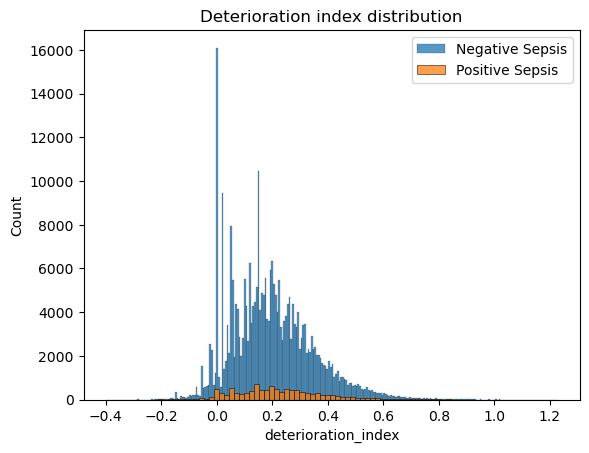

In [32]:
# visualize the index
sepsis_dataset_with_didx = sepsis_dataset_with_didx.rename(columns={"deterioration": "deterioration_index"})
p_positive = sepsis_dataset_with_didx[sepsis_dataset_with_didx['sepsislabel'] == 1]
p_negative = sepsis_dataset_with_didx[sepsis_dataset_with_didx['sepsislabel'] == 0]

sns.histplot(data=p_negative['deterioration_index'], label='Negative Sepsis')
sns.histplot(data=p_positive['deterioration_index'], label='Positive Sepsis')
plt.title("Deterioration index distribution")
plt.legend()

In [34]:
# one hot encode the sex feature (M/F)
one_hot = pd.get_dummies(sepsis_dataset_with_didx['gender'], prefix='gender', dtype='int')

# Join the encoded df
sepsis_dataset_encoded = sepsis_dataset_with_didx.drop('gender',axis = 1)
sepsis_dataset_encoded = sepsis_dataset_encoded.join(one_hot)
sepsis_dataset_encoded

,patient_id,hour,sepsislabel,hr,o2sat,temp,sbp,map,dbp,resp,...,glucose_t_3,lactate_t_3,hct_t_3,bun_t_3,potassium_t_3,magnesium_t_3,calcium_t_3,deterioration_index,gender_0,gender_1
0,9,24,0,85.0,99.0,37.00,119.0,76.0,62.0,18.00,...,123.0,3.600000,37.6,11.0,4.0,1.1,8.0,0.154,0,1
1,9,25,0,88.0,98.0,37.17,125.0,76.0,60.0,16.00,...,123.0,3.600000,37.6,11.0,4.0,1.1,8.0,0.194,0,1
2,9,27,0,90.0,97.0,37.50,124.0,76.0,62.0,18.50,...,123.0,3.600000,37.6,11.0,4.0,1.1,8.0,0.194,0,1
3,9,36,0,90.0,99.5,37.22,111.0,67.0,53.0,21.75,...,123.0,3.600000,37.6,11.0,4.0,1.1,8.0,-0.088,0,1
4,9,29,0,90.0,98.0,37.44,125.0,79.0,65.0,49.00,...,117.5,2.700000,31.0,11.0,3.6,1.1,8.0,0.053,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302722,119982,9,0,96.0,94.0,36.50,116.0,93.0,77.0,18.00,...,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.076,1,0
302723,119982,10,0,98.0,94.0,36.50,118.0,94.0,77.0,17.00,...,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.138,1,0
302724,119982,45,0,98.0,86.0,36.60,119.0,92.0,73.0,22.00,...,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.036,1,0
302725,119982,11,0,99.0,95.0,36.50,118.0,94.0,80.0,17.00,...,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.133,1,0


#### Transform Dataset into Patient-Level Time-Series

Currently, our data is formatted in a row per time step - so the time series for a given paitent would have [x] row entries corresponding to the duration of their time series, [x].  For modeling, this needs to be converted to sequences for each patient.  The sequence will be a single row, with one column per time step (there will be total time steps of LOOKBACK_WINDOW + PREDICTION_HORIZON).  In each column will be a vector of the variables for that patient at that time step.

In [35]:
# set target sequence length for each patient   
target_sequence_length = LOOKBACK_WINDOW + PREDICTION_HORIZON

In [36]:
# helper to filter patient time series to most recent (LOOKBACK_WINDOW + PREDICTION_HORIZON) samples
def truncate_patient_time_series(grouped_df):
  # don't include the positive sepsis time steps - we want to preict 6 hours before
  grouped_df_filtered = grouped_df[grouped_df['sepsislabel'] == 0]

  # filter to get the most recent 
  grouped_df_filtered = grouped_df[grouped_df['hour'] > (max(grouped_df['hour']) - target_sequence_length)]
  grouped_df_filtered = grouped_df_filtered[grouped_df_filtered['hour'] <= (max(grouped_df_filtered['hour']) - PREDICTION_HORIZON)]
  grouped_df_filtered['hour'] = grouped_df_filtered['hour'] - min(grouped_df_filtered['hour'])
  return grouped_df_filtered

# Execute grouping and sequence truncation
ts_limited_sepsis_data = sepsis_dataset_encoded.groupby('patient_id').apply(truncate_patient_time_series).reset_index(drop=True)
ts_limited_sepsis_data

/tmp/ipykernel_19432/9178757.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_limited_sepsis_data = sepsis_dataset_encoded.groupby('patient_id').apply(truncate_patient_time_series).reset_index(drop=True)


,patient_id,hour,sepsislabel,hr,o2sat,temp,sbp,map,dbp,resp,...,glucose_t_3,lactate_t_3,hct_t_3,bun_t_3,potassium_t_3,magnesium_t_3,calcium_t_3,deterioration_index,gender_0,gender_1
0,9,46,1,111.0,97.0,37.39,136.0,106.0,86.0,26.0,...,114.0,1.300000,25.4,22.0,3.0,2.1,7.5,0.031,0,1
1,9,43,0,113.0,97.0,37.72,134.0,101.0,81.0,26.0,...,127.0,1.300000,25.4,21.0,3.3,2.1,7.6,0.031,0,1
2,9,42,0,115.0,98.0,37.72,139.0,105.0,85.0,27.0,...,143.0,1.300000,26.5,22.0,3.6,2.1,7.7,0.049,0,1
3,9,47,1,116.0,96.0,37.72,143.0,109.0,88.0,30.0,...,143.0,1.300000,26.5,22.0,3.9,2.1,7.7,0.259,0,1
4,9,0,0,117.0,98.0,37.72,105.0,79.0,62.0,18.0,...,143.0,1.300000,26.5,22.0,3.9,2.1,7.7,0.246,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186331,119982,5,0,96.0,94.0,36.50,116.0,93.0,77.0,18.0,...,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.076,1,0
186332,119982,6,0,98.0,94.0,36.50,118.0,94.0,77.0,17.0,...,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.138,1,0
186333,119982,41,0,98.0,86.0,36.60,119.0,92.0,73.0,22.0,...,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.036,1,0
186334,119982,7,0,99.0,95.0,36.50,118.0,94.0,80.0,17.0,...,95.0,1.819955,44.6,9.0,4.2,1.9,19.0,0.133,1,0


In [41]:
# narrow down our columns to just the variables
feature_cols = ts_limited_sepsis_data.columns.to_list()
ignore_cols = ['patient_id', 'hour', 'sepsislabel', 'gender', 'sbp', 'sbp_t_1', 'sbp_t_3', 'dbp', 'dbp_t_1', 'dbp_t_3']
feature_cols = [x for x in feature_cols if x not in ignore_cols]

In [42]:
feature_cols

['hr',
 'o2sat',
 'temp',
 'map',
 'resp',
 'wbc',
 'platelets',
 'creatinine',
 'glucose',
 'lactate',
 'hct',
 'bun',
 'potassium',
 'magnesium',
 'calcium',
 'age',
 'hospadmtime',
 'iculos',
 'hr_t_1',
 'o2sat_t_1',
 'temp_t_1',
 'map_t_1',
 'resp_t_1',
 'wbc_t_1',
 'platelets_t_1',
 'creatinine_t_1',
 'glucose_t_1',
 'lactate_t_1',
 'hct_t_1',
 'bun_t_1',
 'potassium_t_1',
 'magnesium_t_1',
 'calcium_t_1',
 'hr_t_3',
 'o2sat_t_3',
 'temp_t_3',
 'map_t_3',
 'resp_t_3',
 'wbc_t_3',
 'platelets_t_3',
 'creatinine_t_3',
 'glucose_t_3',
 'lactate_t_3',
 'hct_t_3',
 'bun_t_3',
 'potassium_t_3',
 'magnesium_t_3',
 'calcium_t_3',
 'deterioration_index',
 'gender_0',
 'gender_1']

In [43]:
# Helper function to perform vectorization of features at each time step
def get_patient_feature_vector(row):
  vector = []
  for col in feature_cols:
    vector.append(row[col])
  return vector

# test on a few samples
v = ts_limited_sepsis_data.head().apply(get_patient_feature_vector, axis=1)
len(v[0])

51

In [44]:
# Apply to the whole dataset
ts_limited_sepsis_data["feature_vector"] = ts_limited_sepsis_data.apply(get_patient_feature_vector, axis=1)
ts_limited_sepsis_data["feature_vector"]

0         [111.0, 97.0, 37.39, 106.0, 26.0, 14.4, 759.0,...
1         [113.0, 97.0, 37.72, 101.0, 26.0, 14.4, 759.0,...
2         [115.0, 98.0, 37.72, 105.0, 27.0, 14.4, 759.0,...
3         [116.0, 96.0, 37.72, 109.0, 30.0, 14.4, 759.0,...
4         [117.0, 98.0, 37.72, 79.0, 18.0, 13.0, 448.0, ...
                                ...                        
186331    [96.0, 94.0, 36.5, 93.0, 18.0, 10.3, 286.0, 1....
186332    [98.0, 94.0, 36.5, 94.0, 17.0, 10.3, 286.0, 1....
186333    [98.0, 86.0, 36.6, 92.0, 22.0, 11.0, 280.0, 0....
186334    [99.0, 95.0, 36.5, 94.0, 17.0, 10.3, 286.0, 1....
186335    [99.0, 94.0, 36.5, 93.0, 21.0, 10.3, 286.0, 1....
Name: feature_vector, Length: 186336, dtype: object

In [45]:
len(ts_limited_sepsis_data.iloc[0]["feature_vector"])

51

In [46]:
# Drop everything except the patient ID, date, and selected features
drop_columns = [col for col in ts_limited_sepsis_data.columns if col not in ['patient_id', 'hour', 'sepsislabel', 'feature_vector']]
ts_limited_sepsis_data.drop(columns=drop_columns, inplace=True)
ts_limited_sepsis_data.head()

,patient_id,hour,sepsislabel,feature_vector
0,9,46,1,"[111.0, 97.0, 37.39, 106.0, 26.0, 14.4, 759.0,..."
1,9,43,0,"[113.0, 97.0, 37.72, 101.0, 26.0, 14.4, 759.0,..."
2,9,42,0,"[115.0, 98.0, 37.72, 105.0, 27.0, 14.4, 759.0,..."
3,9,47,1,"[116.0, 96.0, 37.72, 109.0, 30.0, 14.4, 759.0,..."
4,9,0,0,"[117.0, 98.0, 37.72, 79.0, 18.0, 13.0, 448.0, ..."


In [47]:
# Transform the dataset to have time step as columns, features in each col
ts_limited_sepsis_sequence = ts_limited_sepsis_data.pivot(index="patient_id", columns="hour", values="feature_vector")
ts_limited_sepsis_sequence


hour,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
patient_id,,,,,,,,,,,,,,,,,,,,,
9,"[117.0, 98.0, 37.72, 79.0, 18.0, 13.0, 448.0, ...","[124.0, 99.0, 37.72, 92.0, 16.5, 13.0, 448.0, ...","[127.0, 100.0, 37.72, 100.0, 22.0, 13.0, 448.0...","[131.0, 96.0, 37.72, 94.0, 27.0, 13.0, 448.0, ...","[126.0, 98.0, 37.94, 91.0, 25.0, 13.0, 448.0, ...","[126.0, 100.0, 37.94, 96.0, 21.0, 13.0, 448.0,...","[126.0, 98.0, 37.94, 88.0, 22.0, 13.0, 448.0, ...","[136.0, 96.0, 38.78, 97.0, 30.0, 13.0, 448.0, ...","[133.0, 96.0, 38.78, 77.0, 24.75, 13.0, 448.0,...","[134.0, 96.0, 38.78, 82.0, 26.0, 13.0, 448.0, ...",...,"[135.0, 97.0, 38.67, 101.0, 31.0, 13.6, 693.0,...","[129.0, 98.0, 38.67, 105.0, 29.0, 13.6, 693.0,...","[122.0, 99.0, 38.06, 105.0, 28.0, 13.6, 693.0,...","[121.0, 98.0, 38.06, 109.0, 28.0, 14.4, 759.0,...","[115.0, 98.0, 37.72, 105.0, 27.0, 14.4, 759.0,...","[113.0, 97.0, 37.72, 101.0, 26.0, 14.4, 759.0,...","[119.0, 100.0, 37.94, 106.0, 26.5, 14.4, 759.0...","[118.0, 96.0, 37.94, 108.0, 26.0, 14.4, 759.0,...","[111.0, 97.0, 37.39, 106.0, 26.0, 14.4, 759.0,...","[116.0, 96.0, 37.72, 109.0, 30.0, 14.4, 759.0,..."
18,"[90.0, 100.0, 37.1, 87.0, 13.5, 12.0, 589.0, 0...","[94.0, 100.0, 36.53, 95.5, 19.0, 12.0, 589.0, ...","[93.0, 100.0, 36.53, 74.0, 14.0, 12.0, 589.0, ...","[102.0, 99.5, 37.83, 82.0, 20.0, 12.0, 589.0, ...","[119.0, 97.0, 37.83, 77.0, 22.0, 12.0, 589.0, ...","[122.0, 98.0, 39.72, 70.0, 20.0, 12.0, 589.0, ...","[110.0, 95.0, 39.72, 67.0, 15.0, 12.0, 589.0, ...","[103.0, 95.5, 38.06, 70.0, 22.0, 12.0, 589.0, ...","[98.0, 96.0, 37.5, 73.0, 25.0, 12.0, 589.0, 0....","[103.0, 96.0, 37.5, 71.0, 22.0, 12.0, 589.0, 0...",...,"[109.0, 95.0, 37.72, 83.0, 19.0, 12.3, 641.0, ...","[109.0, 96.0, 37.61, 87.0, 22.5, 12.3, 641.0, ...","[107.0, 95.0, 37.61, 102.0, 25.0, 12.3, 641.0,...","[105.0, 96.0, 37.61, 90.0, 26.0, 12.3, 641.0, ...","[116.0, 95.0, 39.0, 89.0, 24.0, 12.3, 641.0, 0...","[102.0, 95.0, 37.89, 64.5, 25.0, 12.3, 641.0, ...","[110.0, 98.0, 37.89, 84.0, 20.0, 12.3, 641.0, ...","[105.0, 96.0, 37.83, 75.0, 20.0, 12.3, 641.0, ...","[112.0, 96.0, 37.83, 94.0, 21.0, 11.7, 701.0, ...","[116.0, 96.0, 38.61, 99.0, 21.5, 11.7, 701.0, ..."
21,"[93.0, 95.0, 36.44, 80.5, 21.0, 15.2, 205.0, 0...","[94.0, 95.0, 36.44, 70.0, 14.0, 15.2, 205.0, 0...","[96.5, 94.0, 37.56, 65.0, 14.0, 15.2, 205.0, 0...","[97.0, 96.0, 38.0, 61.0, 14.0, 15.2, 205.0, 0....","[92.0, 95.0, 37.39, 61.0, 15.0, 15.2, 205.0, 0...","[99.0, 93.0, 37.28, 61.0, 16.0, 15.2, 205.0, 0...","[98.0, 94.0, 37.28, 62.0, 15.0, 15.2, 205.0, 0...","[97.0, 93.0, 37.56, 63.0, 18.0, 15.2, 205.0, 0...","[93.0, 94.0, 37.56, 64.0, 17.0, 15.2, 205.0, 0...","[106.0, 93.0, 37.56, 62.0, 17.0, 15.2, 205.0, ...",...,"[113.0, 94.5, 36.72, 99.0, 31.0, 16.4, 218.0, ...","[101.0, 99.0, 36.72, 109.0, 32.0, 16.4, 218.0,...","[94.0, 92.0, 36.72, 92.0, 27.0, 16.4, 218.0, 0...","[94.0, 92.0, 36.72, 92.0, 27.0, 16.4, 218.0, 0...","[100.0, 94.0, 36.56, 85.0, 31.0, 16.4, 218.0, ...","[100.0, 95.0, 36.56, 90.0, 27.0, 16.4, 218.0, ...","[91.0, 93.0, 36.56, 72.0, 21.0, 16.4, 218.0, 0...","[104.0, 91.0, 36.56, 80.0, 35.0, 16.4, 218.0, ...","[102.0, 94.0, 36.67, 108.0, 28.0, 16.4, 218.0,...","[102.0, 92.0, 36.67, 91.0, 32.0, 16.4, 218.0, ..."
31,"[65.0, 100.0, 36.5, 83.5, 15.0, 10.4, 326.0, 0...","[74.5, 99.5, 36.5, 83.0, 16.0, 10.4, 326.0, 0....","[74.0, 100.0, 36.5, 79.0, 15.0, 10.4, 326.0, 0...","[79.0, 99.0, 37.39, 76.0, 15.0, 10.4, 326.0, 0...","[89.0, 98.0, 37.39, 71.0, 15.0, 10.4, 326.0, 0...","[82.0, 100.0, 37.39, 81.0, 15.0, 10.4, 326.0, ...","[84.0, 100.0, 37.39, 84.0, 17.0, 10.4, 326.0, ...","[96.0, 100.0, 37.39, 81.0, 17.0, 10.4, 326.0, ...","[94.0, 100.0, 38.39, 83.0, 15.0, 10.4, 326.0, ...","[97.0, 100.0, 38.39, 88.0, 20.0, 10.4, 326.0, ...",...,"[62.0, 98.0, 37.89, 85.0, 15.0, 10.1, 263.0, 0...","[70.0, 97.0, 37.89, 84.0, 15.0, 10.1, 263.0, 0...","[97.0, 97.0, 37.56, 85.0, 16.0, 10.1, 263.0, 0...","[96.0, 97.0, 37.56, 79.0, 16.0, 10.1, 263.0, 0...","[69.0, 99.0, 37.56, 79.0, 15.0, 1

In [48]:
# helper to re-map target value to patient in ts dataset
def remap_sepsis_outcome_to_patient_ts(patient_ts_row):
    p_id = patient_ts_row['patient_id']
    patient_ts_row['sepsislabel'] = sepsis_dataset[sepsis_dataset['patient_id'] == p_id]['sepsislabel'].max()
    return patient_ts_row

ts_limited_sepsis_sequence_label = ts_limited_sepsis_sequence.reset_index().apply(remap_sepsis_outcome_to_patient_ts, axis=1)

In [49]:
# grab just the patient label column for use later as our target var
patient_sequence_sepsis_label = ts_limited_sepsis_sequence_label['sepsislabel']
patient_sequence_sepsis_label = np.array(patient_sequence_sepsis_label.to_list())
patient_sequence_sepsis_label.shape

(3882,)

In [50]:
# Convert the data to an array
patient_sepsis_sequences = np.array(ts_limited_sepsis_sequence.values.tolist())
patient_sepsis_sequences.shape

(3882, 48, 51)

In [52]:
ts_limited_sepsis_sequence.values.tolist()[0][0]

[117.0,
 98.0,
 37.72,
 79.0,
 18.0,
 13.0,
 448.0,
 0.8,
 124.0,
 1.5,
 23.1,
 22.0,
 3.7,
 2.0,
 8.1,
 27.92,
 -0.03,
 205.0,
 111.0,
 99.0,
 38.11,
 88.0,
 17.0,
 7.2,
 175.0,
 0.9,
 143.0,
 1.3,
 26.5,
 22.0,
 3.9,
 2.1,
 7.7,
 111.0,
 99.0,
 38.11,
 88.0,
 17.0,
 7.2,
 175.0,
 0.9,
 143.0,
 1.3,
 26.5,
 22.0,
 3.9,
 2.1,
 7.7,
 0.246,
 0.0,
 1.0]

### Split Dataset

In [53]:
# shuffle the dataset
indices = np.arange(patient_sepsis_sequences.shape[0])
np.random.seed(23)
np.random.shuffle(indices, )

X = patient_sepsis_sequences[indices]
y = patient_sequence_sepsis_label[indices]

In [54]:
# Split the data into test/train/val sets with a 80/10/10 split
n = X.shape[0]
X_train = X[:int(n*0.8), :, :]
y_train = y[:int(n*0.8)]

X_test = X[int(n*0.8):int(n*0.9), :, :]
y_test = y[int(n*0.8):int(n*0.9)]

X_val = X[int(n*0.9):, :, :]
y_val = y[int(n*0.9):]

print(f"Train data shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Test data shape: X: {X_test.shape}, y: {y_test.shape}")
print(f"Validation data shape: X: {X_val.shape}, y: {y_val.shape}")

Train data shape: X: (3105, 48, 51), y: (3105,)
Test data shape: X: (388, 48, 51), y: (388,)
Validation data shape: X: (389, 48, 51), y: (389,)


#### Scale/Normalize Continuous Features

In [55]:
# Will apply standard scaling to the continuous features
scaler = StandardScaler()

# setup index to apply only to cont features -- NOT SCALING Det Index
num_continuous_features = len(feature_cols) - 3
num_continuous_features

48

In [56]:
# We need to temporarily flatten our datasets as scaler supports only two dims
X_train_2d = X_train.reshape(-1, X_train.shape[2])
X_test_2d = X_test.reshape(-1, X_test.shape[2])
X_val_2d = X_val.reshape(-1, X_val.shape[2])

print(f"Train data flattened shape: X: {X_train_2d.shape}")
print(f"Test data flattened shape: X: {X_test_2d.shape}")
print(f"Validation data flattened shape: X: {X_val_2d.shape}")

Train data flattened shape: X: (149040, 51)
Test data flattened shape: X: (18624, 51)
Validation data flattened shape: X: (18672, 51)


In [57]:
# apply scaling to continuous features only
X_train_2d[:, :num_continuous_features] = scaler.fit_transform(X_train_2d[:, :num_continuous_features])
X_test_2d[:, :num_continuous_features] = scaler.transform(X_test_2d[:, :num_continuous_features])
X_val_2d[:, :num_continuous_features] = scaler.transform(X_val_2d[:, :num_continuous_features])

In [58]:
# reshape back to original
X_train_norm = X_train_2d.reshape(X_train.shape)
X_test_norm = X_test_2d.reshape(X_test.shape)
X_val_norm = X_val_2d.reshape(X_val.shape)

print(f"Train data un-flattened shape: X: {X_train_norm.shape}")
print(f"Test data un-flattened shape: X: {X_test_norm.shape}")
print(f"Validation data un-flattened shape: X: {X_val_norm.shape}")

Train data un-flattened shape: X: (3105, 48, 51)
Test data un-flattened shape: X: (388, 48, 51)
Validation data un-flattened shape: X: (389, 48, 51)


In [59]:
# Save mean and standard deviation arrays to S3
scaler_mean = scaler.mean_
scaler_stddev = scaler.scale_

print(f"Scaler mean: {scaler_mean} and std dev: {scaler_stddev}")

np.save(f"{local_data_path_csv}/scaler_mean.npy", scaler_mean)
np.save(f"{local_data_path_csv}/scaler_stddev.npy", scaler_stddev)

Scaler mean: [ 86.24514728  97.15120773  36.93236834  82.78228096  19.16935473
  11.51232007 207.00766289   1.49242969 132.67222495   1.80408645
  31.12147233  25.8020957    4.06370459   2.0670089    8.04263142
  62.64175201 -71.09330757  49.61078905  86.54376006  97.19458535
  36.92392579  82.76710877  19.07026724  11.59927332 205.71397513
   1.51896149 133.52379499   1.83419114  31.12070711  25.6523822
   4.06969956   2.06069046   7.98921017  86.54376006  97.19458535
  36.92392579  82.76710877  19.07026724  11.59927332 205.71397513
   1.51896149 133.52379499   1.83419114  31.12070711  25.6523822
   4.06969956   2.06069046   7.98921017] and std dev: [ 18.13704565   3.11793741   0.76503963  16.39168037   5.58036148
   6.85650576 107.18202815   1.67884256  46.61722016   0.9479452
   5.6102187   20.96750038   0.58333879   0.37722344   1.80489817
  16.22928864 207.31039539  49.89659884  18.1857459    3.13545923
   0.77290164  16.54714229   5.58574275   7.92093185 106.01140487
   1.7287713

In [60]:
# Save datasets locally
np.save(f"{local_data_path_csv}/X_train.npy", X_train)
np.save(f"{local_data_path_csv}/y_train.npy", y_train)

np.save(f"{local_data_path_csv}/X_test.npy", X_test)
np.save(f"{local_data_path_csv}/y_test.npy", y_test)

np.save(f"{local_data_path_csv}/X_val.npy", X_val)
np.save(f"{local_data_path_csv}/y_val.npy", y_val)

In [61]:
# Set session variables
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_session.region_name
bucket = sess.default_bucket()

##### Store results in S3

In [62]:
# copy the dataset files to the datalake
!aws s3 cp $local_data_path_csv $s3_datalake_path_prepared --recursive --exclude "*" --include "*.npy"

upload: ../data/scaler_stddev.npy to s3://sagemaker-us-east-1-343218227212/sepsis-prediction/prepared/scaler_stddev.npy
upload: ../data/scaler_mean.npy to s3://sagemaker-us-east-1-343218227212/sepsis-prediction/prepared/scaler_mean.npy
upload: ../data/y_train.npy to s3://sagemaker-us-east-1-343218227212/sepsis-prediction/prepared/y_train.npy
upload: ../data/y_val.npy to s3://sagemaker-us-east-1-343218227212/sepsis-prediction/prepared/y_val.npy
upload: ../data/y_test.npy to s3://sagemaker-us-east-1-343218227212/sepsis-prediction/prepared/y_test.npy
upload: ../data/X_val.npy to s3://sagemaker-us-east-1-343218227212/sepsis-prediction/prepared/X_val.npy
upload: ../data/X_test.npy to s3://sagemaker-us-east-1-343218227212/sepsis-prediction/prepared/X_test.npy
upload: ../data/X_train.npy to s3://sagemaker-us-east-1-343218227212/sepsis-prediction/prepared/X_train.npy
